# Charts and Plots for The Paper

Below we just render some of the data we have for optimal presentation in the paper.

## Simulation vs Real Data

In [1]:
# Travel Product Market Research
#
# Agents are surveyed about their interest in a new travel product. They can only say "yes" or "no".

travel_experiment_title = "WanderLux Travel Product Market Research"

# Simulated Data
sim_singles_choose_yes = 13
sim_couples_choose_yes = 22
sim_families_choose_yes = 5

sim_singles_choose_no = 37
sim_couples_choose_no = 28
sim_families_choose_no = 45

# Real Data
real_singles_choose_yes = 21
real_couples_choose_yes = 33
real_families_choose_yes = 28

real_singles_choose_no = 29
real_couples_choose_no = 17
real_families_choose_no = 22

In [2]:
# Bottled Gazpacho Market Research
#
# Agents are surveyed about their interest in a new bottled gazpacho product. They can rate their interest from 1 (no interest) to 5 (complete interest).

gazpacho_experiment_title = "Bottled Gazpacho Market Research"

# Simulated Data
sim_ratings = {1: 2, 2: 19, 3: 25, 4: 4, 5:0}

# Real Data
real_ratings = {1: 11, 2: 9, 3: 13, 4: 10, 5: 7}


Now let's produce a beautiful plot comparing the simulation results to the real data. Each experiment should be shown in separate columns (refer to the first as "(a)" and to the second as "(b)"). For the real data, let's use besides color also dash style to differentiate the lines. Let's also add a legend to the plot.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Prepare travel experiment dataframe
travel_records = [
    ("Singles", "Simulation", "Yes", sim_singles_choose_yes),
    ("Singles", "Simulation", "No", sim_singles_choose_no),
    ("Couples", "Simulation", "Yes", sim_couples_choose_yes),
    ("Couples", "Simulation", "No", sim_couples_choose_no),
    ("Families", "Simulation", "Yes", sim_families_choose_yes),
    ("Families", "Simulation", "No", sim_families_choose_no),
    ("Singles", "Real", "Yes", real_singles_choose_yes),
    ("Singles", "Real", "No", real_singles_choose_no),
    ("Couples", "Real", "Yes", real_couples_choose_yes),
    ("Couples", "Real", "No", real_couples_choose_no),
    ("Families", "Real", "Yes", real_families_choose_yes),
    ("Families", "Real", "No", real_families_choose_no),
]
travel_df = pd.DataFrame(travel_records, columns=["group", "source", "response", "count"])
travel_df["proportion"] = travel_df.groupby(["group", "source"])["count"].transform(
    lambda x: x / x.sum()
)

# Prepare gazpacho experiment dataframe (single population)
def _expand_rating_dict(source_label, rating_dict):
    for rating, count in rating_dict.items():
        yield source_label, int(rating), count

gazpacho_records = list(_expand_rating_dict("Simulation", sim_ratings)) + list(
    _expand_rating_dict("Real", real_ratings)
)

gazpacho_df = pd.DataFrame(gazpacho_records, columns=["source", "rating", "count"])
gazpacho_df["share"] = gazpacho_df.groupby("source")["count"].transform(
    lambda x: x / x.sum()
)
gazpacho_df["rating"] = gazpacho_df["rating"].astype(int)

# Compute aggregate means for controls (Simulation) and treatments (Real)
travel_control_mean = (
    travel_df.query('source == "Simulation" and response == "Yes"')["count"].sum()
    / travel_df.query('source == "Simulation"')["count"].sum()
)
travel_treatment_mean = (
    travel_df.query('source == "Real" and response == "Yes"')["count"].sum()
    / travel_df.query('source == "Real"')["count"].sum()
)

def _weighted_average(df, value_col="rating", weight_col="count"):
    return (df[value_col] * df[weight_col]).sum() / df[weight_col].sum()

gazpacho_control_mean = _weighted_average(gazpacho_df.query('source == "Simulation"'))
gazpacho_treatment_mean = _weighted_average(gazpacho_df.query('source == "Real"'))

control_treatment_means = {
    "Travel": {"control": travel_control_mean, "treatment": travel_treatment_mean},
    "Gazpacho": {"control": gazpacho_control_mean, "treatment": gazpacho_treatment_mean},
}

sns.set_theme(style="whitegrid")

In [8]:
def render_sim_vs_real(fig_width=34, fig_height=7, font_scale=1.0):
    """Render the (a)/(b) side-by-side charts.

    Args:
        fig_width: Figure width in inches.
        fig_height: Figure height in inches.
        font_scale: Multiplier applied to all font sizes (1.0 keeps current sizes).
    """
    # Create professional side-by-side comparison charts.
    from matplotlib.ticker import PercentFormatter
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    # ...existing code... (style toggles / constants can stay here; kept identical)
    SHOW_MEAN_LINES_TRAVEL = False
    SHOW_LEGEND_TRAVEL = True
    SHOW_MEAN_LINES = True

    TITLE_FONT_SIZE = 30 * font_scale
    LABEL_FONT_SIZE = 26 * font_scale
    TICK_FONT_SIZE = 24 * font_scale
    LEGEND_TITLE_FONT_SIZE = 24 * font_scale
    LEGEND_TEXT_FONT_SIZE = 22 * font_scale
    MEAN_LABEL_FONT_SIZE = 20 * font_scale
    MEAN_LINE_WIDTH = 4.0

    dataset_order = ["Simulation", "Real"]
    group_order = ["Singles", "Couples", "Families"]
    rating_order = sorted(gazpacho_df["rating"].unique())

    travel_yes_colors = {"Simulation": "#4C6EF5", "Real": "#D7263D"}
    source_hatches = {"Simulation": "", "Real": "//"}
    dataset_colors = {"Simulation": "#2A9D8F", "Real": "#E9C46A"}
    mean_line_styles = {
        source: {
            "color": dataset_color,
            "linestyle": (0, (3, 2)) if source == "Simulation" else (0, (1, 1)),
            "linewidth": MEAN_LINE_WIDTH,
            "alpha": 0.9,
            "zorder": 5,
        }
        for source, dataset_color in dataset_colors.items()
    }

    fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_height), sharey=False)

    # Panel (a): Travel yes proportions as grouped bars
    n_groups = len(group_order)
    n_sources = len(dataset_order)
    group_positions = np.arange(n_groups)
    bar_width = 0.6 / n_sources

    for source_index, source in enumerate(dataset_order):
        subset = (
            travel_df
            .query("response == 'Yes' and source == @source")
            .set_index("group")
            .loc[group_order]
        )
        offsets = group_positions + (source_index - (n_sources - 1) / 2) * bar_width
        axes[0].bar(
            offsets,
            subset["proportion"],
            width=bar_width * 0.95,
            color=travel_yes_colors[source],
            edgecolor="black",
            linewidth=0.9,
            hatch=source_hatches[source],
            label=f"Yes ({source.lower()})",
        )

    axes[0].set_title(f"(a) {travel_experiment_title}", fontsize=TITLE_FONT_SIZE, pad=16)
    axes[0].set_ylabel("Share of responses", fontsize=LABEL_FONT_SIZE)
    axes[0].set_xlabel("Household type", fontsize=LABEL_FONT_SIZE)
    axes[0].set_xticks(group_positions)
    axes[0].set_xticklabels(group_order, fontsize=TICK_FONT_SIZE)
    axes[0].set_ylim(0, 1.05)
    axes[0].yaxis.set_major_formatter(PercentFormatter(1.0))
    axes[0].tick_params(axis="y", labelsize=TICK_FONT_SIZE)
    axes[0].set_xlim(-0.6, n_groups - 0.4)

    if SHOW_MEAN_LINES_TRAVEL:
        x_limits = axes[0].get_xlim()
        x_for_label = x_limits[1] - 0.15
        for source in dataset_order:
            mean_value = control_treatment_means["Travel"]["control" if source == "Simulation" else "treatment"]
            style = mean_line_styles[source]
            axes[0].axhline(
                mean_value,
                color=style["color"],
                linestyle=style["linestyle"],
                linewidth=style["linewidth"],
                alpha=style["alpha"],
                zorder=style["zorder"],
            )
            axes[0].text(
                x_for_label,
                mean_value,
                f"{source} yes mean: {mean_value:.1%}",
                color=style["color"],
                fontsize=MEAN_LABEL_FONT_SIZE,
                va="bottom" if source == "Simulation" else "top",
                ha="right",
                alpha=0.85,
            )
    if SHOW_LEGEND_TRAVEL:
        yes_handles = [
            Patch(
                facecolor=travel_yes_colors[source],
                edgecolor="black",
                linewidth=0.9,
                hatch=source_hatches[source],
                label=f"Yes, would use the product ({source.lower()})",
            )
            for source in dataset_order
        ]
        legend1 = axes[0].legend(
            handles=yes_handles,
            title="Response",
            loc="upper left",
            frameon=True,
        )
        plt.setp(legend1.get_title(), fontsize=LEGEND_TITLE_FONT_SIZE)
        for text in legend1.get_texts():
            text.set_fontsize(LEGEND_TEXT_FONT_SIZE)

    # Panel (b): Gazpacho rating distributions as grouped bars for a single population
    rating_positions = np.array(rating_order, dtype=float)
    bar_width_b = 0.32

    for source_index, source in enumerate(dataset_order):
        subset = (
            gazpacho_df
            .query("source == @source")
            .set_index("rating")
            .loc[rating_order]
        )
        offsets = rating_positions + (source_index - (len(dataset_order) - 1) / 2) * bar_width_b
        axes[1].bar(
            offsets,
            subset["share"],
            width=bar_width_b * 0.95,
            color=dataset_colors[source],
            edgecolor="black",
            linewidth=0.9,
            hatch=source_hatches[source],
            label=f"{source} distribution",
        )

    axes[1].set_title(f"(b) {gazpacho_experiment_title}", fontsize=TITLE_FONT_SIZE, pad=16)
    axes[1].set_xlabel("Interest rating", fontsize=LABEL_FONT_SIZE)
    axes[1].set_ylabel("Share of respondents", fontsize=LABEL_FONT_SIZE)
    axes[1].set_xticks(rating_positions)
    axes[1].set_xticklabels([str(r) for r in rating_order], fontsize=TICK_FONT_SIZE)
    axes[1].set_xlim(rating_positions[0] - 0.5, rating_positions[-1] + 0.5)
    axes[1].set_ylim(0, min(1.0, gazpacho_df["share"].max() * 1.2))
    axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))
    axes[1].tick_params(axis="y", labelsize=TICK_FONT_SIZE)

    source_handles_panel_b = [
        Patch(
            facecolor=dataset_colors[source],
            edgecolor="black",
            linewidth=0.9,
            hatch=source_hatches[source],
            label=f"{source}",
        )
        for source in dataset_order
    ]
    legend_distributions = axes[1].legend(
        handles=source_handles_panel_b, title="Data source", loc="upper right", frameon=True
    )
    plt.setp(legend_distributions.get_title(), fontsize=LEGEND_TITLE_FONT_SIZE)
    for text in legend_distributions.get_texts():
        text.set_fontsize(LEGEND_TEXT_FONT_SIZE)
    legend_means = None

    if SHOW_MEAN_LINES:
        gazpacho_mean_map = {
            "Simulation": control_treatment_means["Gazpacho"]["control"],
            "Real": control_treatment_means["Gazpacho"]["treatment"],
        }
        mean_handles = []
        for source, mean_value in gazpacho_mean_map.items():
            style = mean_line_styles[source]
            axes[1].axvline(
                mean_value,
                ymin=0,
                ymax=1,
                color=style["color"],
                linestyle=style["linestyle"],
                linewidth=style["linewidth"],
                alpha=style["alpha"],
                zorder=style["zorder"],
            )
            mean_handles.append(
                Line2D(
                    [0, 1],
                    [0, 1],
                    color=style["color"],
                    linestyle=style["linestyle"],
                    linewidth=style["linewidth"],
                    alpha=style["alpha"],
                    label=f"{source} mean ({mean_value:.2f})".format("", mean_value)
                )
            )
        legend_means = axes[1].legend(
            handles=mean_handles, title="Mean rating", loc="upper left", frameon=True
        )
        plt.setp(legend_means.get_title(), fontsize=LEGEND_TITLE_FONT_SIZE)
        for text in legend_means.get_texts():
            text.set_fontsize(LEGEND_TEXT_FONT_SIZE)

    if legend_means is not None:
        axes[1].add_artist(legend_means)
    axes[1].add_artist(legend_distributions)

    for ax in axes:
        ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.6)
        ax.set_axisbelow(True)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)

    fig.tight_layout(pad=2.8)
    plt.show()




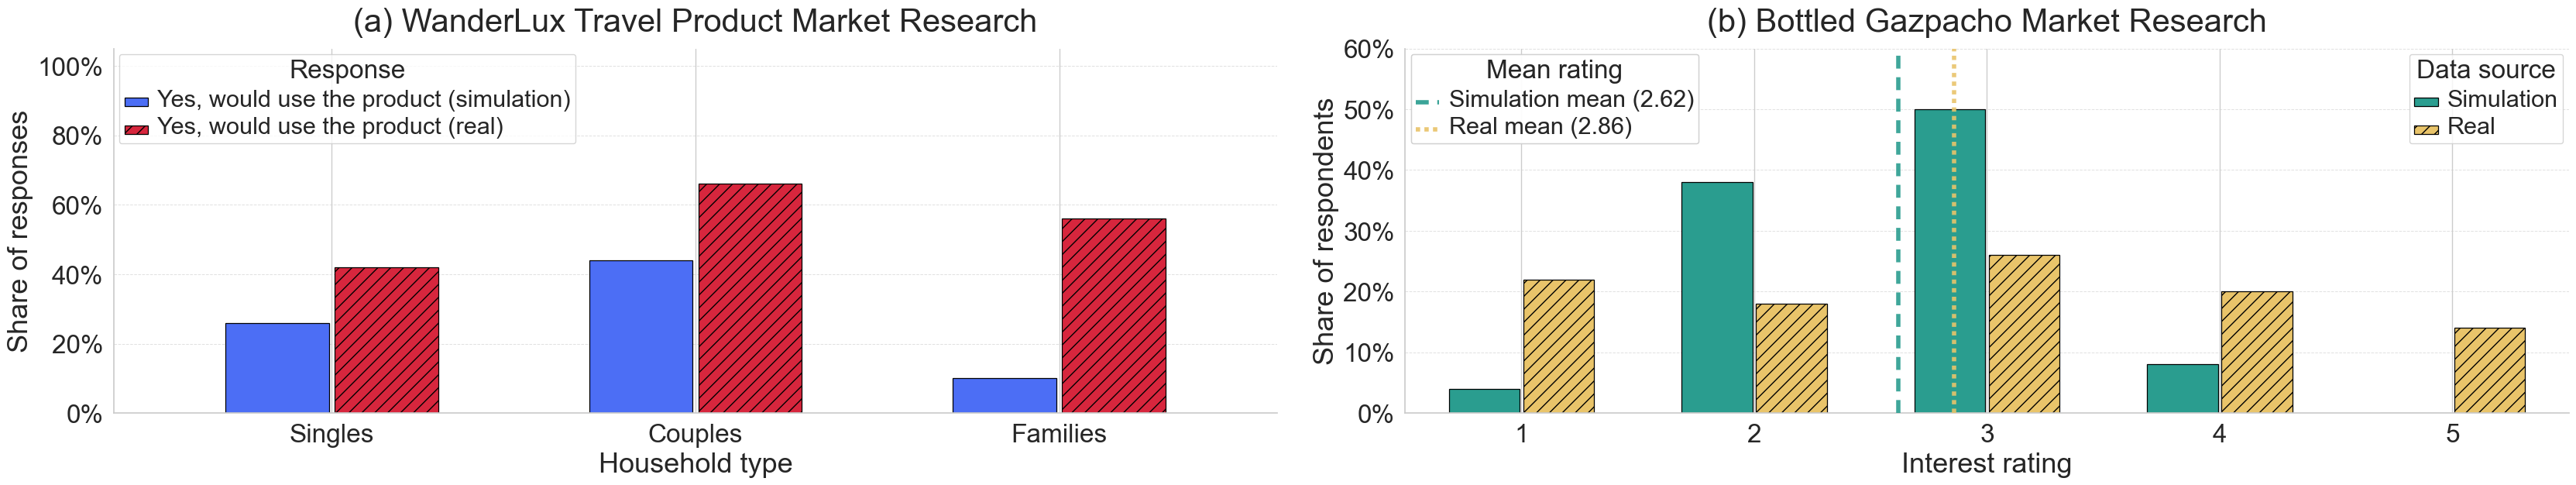

In [11]:
# One call using the current figure size
render_sim_vs_real(fig_width=34, fig_height=7, font_scale=1.0)

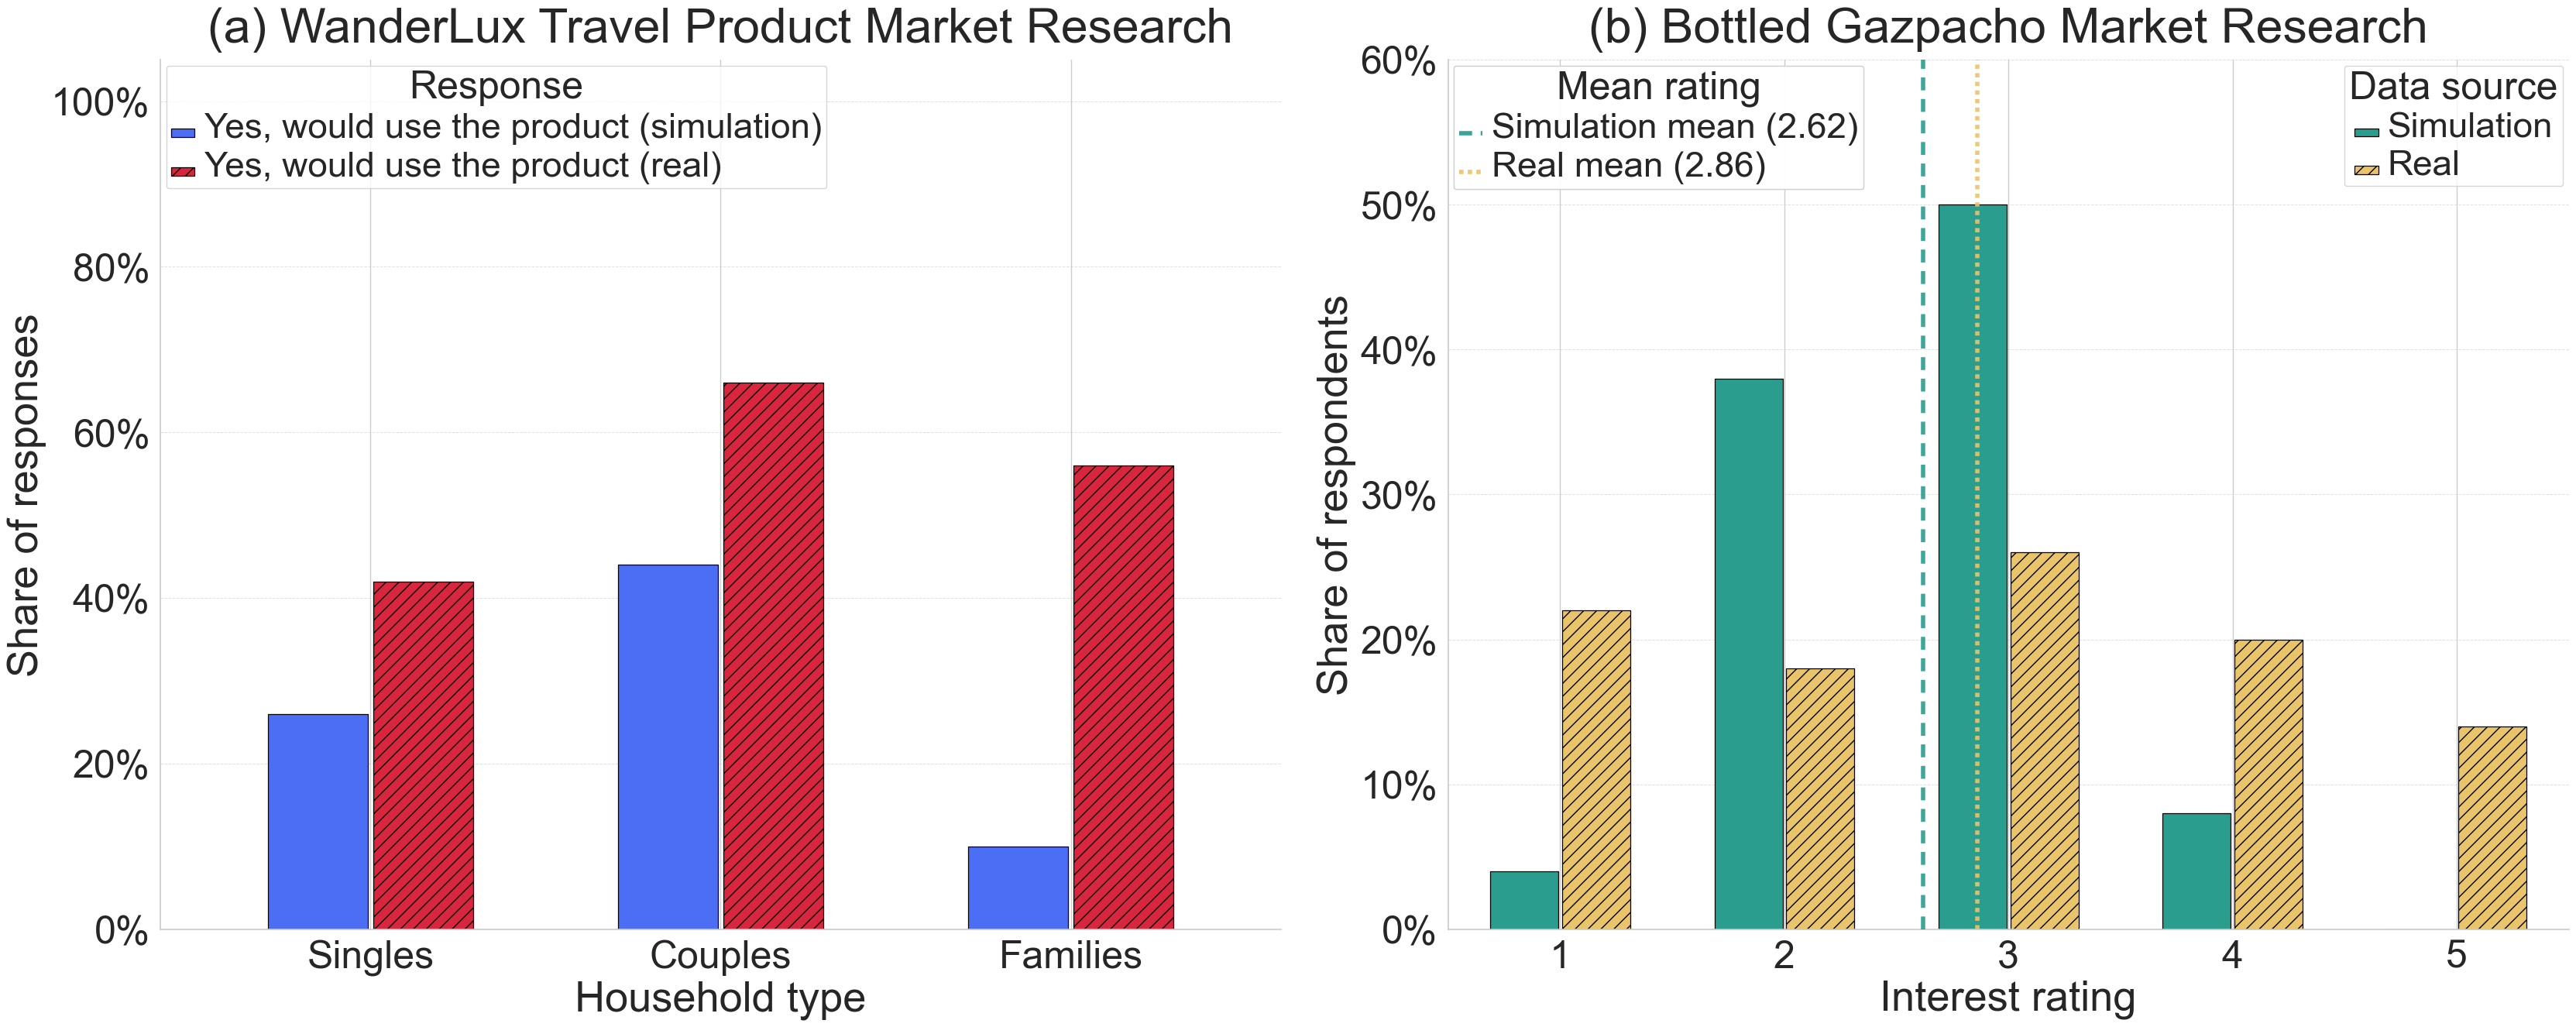

In [9]:
# One call using the current figure size
render_sim_vs_real(fig_width=34, fig_height=14, font_scale=1.5)